The following lines of code will include mainly the Exploratory Data Analysis with few data preparation techniques needed for the visualisations,
The EDA findings will be just above the relevant cells

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [2]:
df = pd.read_csv('spambase_v6.csv')

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
df.head()

,Unnamed: 0,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
0,0,0.00,0.64,0.64,0.0,0.32,0.00,0,0,0.00,0.00,0.00,0.64,0.00,0,0,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0,0.00,0.0,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,True
1,1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,True
2,2,0.06,0,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,True
3,3,0.00,0,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0,0,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0,0.00,0.0,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,True
4,4,0.00,0,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0,0,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0,0.00,0.0,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,True


I noticed that some columns have null values, and some columns were not numerical
So I extracted these columns to inspect them
I noticed that some of them had values like 'zero', '?', 'none' and some were empty, so I changed the column data type to numeric and the undesired values to null values.
The dataset was not big in size and ratio of these null values was very low (max %5) so I chose to keep them and change these NA's to 0's.
Also, I had a column 'Unnamed: 0' that is not relevant our project, so I dropped it.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 59 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  4601 non-null   int64  
 1   word_freq_make              4601 non-null   float64
 2   word_freq_address           4601 non-null   object 
 3   word_freq_all               4595 non-null   float64
 4   word_freq_3d                4599 non-null   float64
 5   word_freq_our               4601 non-null   object 
 6   word_freq_over              4600 non-null   float64
 7   word_freq_remove            4601 non-null   object 
 8   word_freq_internet          4586 non-null   object 
 9   word_freq_order             4601 non-null   float64
 10  word_freq_mail              4601 non-null   float64
 11  word_freq_receive           4601 non-null   float64
 12  word_freq_will              4601 non-null   float64
 13  word_freq_people            4601 

In [5]:
# Extracted columns with object data type to inspect them
columns_to_change = df.select_dtypes(exclude=['float64','int64','bool'])
columns_to_change

,word_freq_address,word_freq_our,word_freq_remove,word_freq_internet,word_freq_report,word_freq_addresses,word_freq_000,word_freq_hpl,word_freq_labs
0,0.64,0.32,0,0,0,0,0,0,NaN
1,0.28,0.14,0.21,0.07,0.21,0.14,0.43,0,NaN
2,0,1.23,0.19,0.12,0,1.75,1.16,0,NaN
3,0,0.63,0.31,0.63,0,0,0,0,NaN
4,0,0.63,0.31,0.63,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...
4596,0,0,0,0,0,zero,0,0,0
4597,0,0,0,0,0,0,0,0,0
4598,0,0,0,0,0,0,0,0,0
4599,0,0.32,0,0,0,0,0,0,0


In [6]:
print(df['word_freq_our'].unique())


['0.32' '0.14' '1.23' '0.63' '1.85' '1.92' '1.88' '0.61' '0.19' '0' '0.38'
 '0.34' '0.9' '0.71' '1.27' '0.94' '1.11' '1.59' '0.76' '2.94' '1.16'
 '0.65' '1.89' '1.46' '0.48' '0.41' '0.52' '0.45' '1.57' '0.05' '0.42'
 '0.23' '1.39' '0.68' '1.32' '1.26' '0.53' '0.44' '0.46' '1.44' '0.18'
 '1.67' '1.28' '1.4' '1.15' '0.4' '2.24' '0.35' '0.43' '4.25' '0.95'
 '0.88' '0.51' '0.1' '2.23' '0.15' '0.92' '0.33' '1.51' '1.6' '0.56'
 '0.66' '1.49' '1.65' '0.29' '0.81' '2.25' '2.7' '0.62' '1.31' '1.36'
 '0.85' '0.27' '2.1' '0.3' '0.26' '0.5' '0.54' '0.89' '0.08' '0.87' '0.11'
 '6.25' '0.8' '2.19' '1.17' '0.55' '1.77' '2.5' '0.25' '0.96' '1.03'
 '0.39' '0.64' '0.69' '1.81' '1.09' '0.22' '0.31' '1.38' '0.99' '1.24'
 '2.33' '0.75' '1.14' '0.2' '0.78' '1.63' '1.29' '0.16' '0.58' '0.91'
 '0.17' '2' '0.36' '1.93' '1.3' '0.02' '7.69' '0.67' '1.22' '1.48' '0.7'
 '1.21' '1.78' '1.52' '0.59' '1.55' '1.05' '3.48' '0.84' '0.24' '0.28'
 '1.25' '0.09' '1.82' '0.6' '1.34' '1.79' '0.82' '1.02' '1.07' '0.13'
 '0.12

In [7]:
# changed the columns types to float, values like (zero, ???, None) will become null values
columns_to_change = columns_to_change.columns.tolist()
df[columns_to_change] = df[columns_to_change].apply(pd.to_numeric, errors='coerce')

In [8]:
# checking the number of null values within the dataframe
print(df.isna().sum())


Unnamed: 0                      0
word_freq_make                  0
word_freq_address               1
word_freq_all                   6
word_freq_3d                    2
word_freq_our                   1
word_freq_over                  1
word_freq_remove                1
word_freq_internet             16
word_freq_order                 0
word_freq_mail                  0
word_freq_receive               0
word_freq_will                  0
word_freq_people                0
word_freq_report                1
word_freq_addresses           321
word_freq_free                  0
word_freq_business              0
word_freq_email                 0
word_freq_you                   0
word_freq_credit                0
word_freq_your                  0
word_freq_font                  0
word_freq_000                   1
word_freq_money                 0
word_freq_hp                    0
word_freq_hpl                   1
word_freq_george                0
word_freq_650                   0
word_freq_lab 

In [9]:
# fill null values with 0's
df = df.fillna(0)
# dropped first column as it is not relevant
df = df.drop(columns='Unnamed: 0')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

The previous lines of code were necessary in order to visualise our data, and even to implement the model as we can not proceed with missing or unwanted values, so that had to be prioritised at first.
In the next few lines, we will explore our data with different vizualisations that will give us few insights and more information about the overall structure, which will be so helpful in building a good model.

The first finding I noticed, is that we have a large number of features, leading to a highly dimensional dataset, 57 features would definitely affect the performance of the model we will choose and this needs to be taken care of before the modelling stage. Later on, just below the correlation matrix, I will be discussing what am I going to do regarding this high dimensionality.

In [11]:
df['is_spam'].value_counts()


is_spam
False    2788
True     1813
Name: count, dtype: int64

From the distribution of our emails, 2788 non-spam (60.6%) vs. 1813 spam emails (39.4%), we notice a very slight imbalance.
While imbalance can affect building a classification model, it is not a major problem in our case, however I would consider including a decision-tree based algorithm as they perform slightly better with imbalanced variables. 
Again, this is not a major issue and 60/40 is generally acceptable, so we wouldn't be going towards resampling techniques like Synthetic Minority Oversampling Technique (SMOTE), but there is no harm in choosing an algorithm known to have better handling of imbalanced data (mmalinda, 2020).

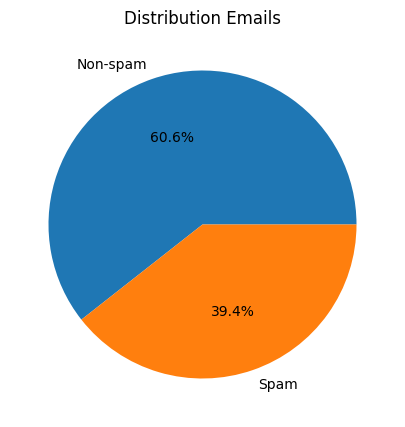

In [12]:
## Distrbution of spam and non spam emails
plt.figure(figsize=(10,5))
counts = df['is_spam'].value_counts()
plt.pie(counts, labels=['Non-spam','Spam'],autopct='%1.1f%%')
plt.title("Distribution Emails")
plt.show()

I implemented the correlation matrix and heatmap to see if there's any correlations between our target variable 'is_spam' and any other variables.
There was not any strong correlations and the stronget we could get was 0.38 with the word 'your' and that doesn't really tell us anything.
So I decided to extract the top 10 correlated features (as the correlation heatmap was huge with 58 features)

In [13]:
cormat = df.corr()
round(cormat,2)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
word_freq_make,1.00,-0.02,0.07,0.01,0.02,0.06,0.01,-0.00,0.11,0.04,0.19,0.11,0.07,0.04,0.03,0.06,0.08,0.05,0.13,0.02,0.20,-0.02,0.13,0.19,-0.07,-0.06,-0.07,-0.05,-0.04,-0.05,-0.04,-0.03,-0.04,-0.03,-0.04,-0.05,-0.06,-0.01,-0.01,-0.04,-0.01,-0.03,-0.02,-0.02,-0.04,-0.03,-0.00,-0.02,-0.03,-0.02,-0.03,0.06,0.12,-0.01,0.04,0.06,0.09,0.13
word_freq_address,-0.02,1.00,-0.03,-0.01,-0.02,-0.02,0.00,-0.02,-0.00,0.03,-0.01,-0.04,-0.02,-0.01,0.01,-0.01,-0.02,0.03,-0.06,-0.02,-0.02,-0.01,-0.02,0.00,-0.04,-0.04,-0.03,-0.03,-0.02,-0.03,-0.02,-0.00,-0.02,-0.00,-0.02,-0.03,-0.02,-0.01,-0.02,-0.01,-0.02,-0.03,-0.00,-0.02,-0.02,-0.02,-0.01,-0.02,-0.01,-0.05,-0.02,-0.01,-0.01,0.00,0.00,0.00,-0.02,-0.03
word_freq_all,0.07,-0.03,1.00,-0.02,0.08,0.09,0.04,0.01,0.09,0.03,0.05,0.08,0.05,0.01,0.12,0.06,0.04,0.12,0.14,0.03,0.16,-0.04,0.12,0.04,-0.09,-0.06,-0.11,-0.05,-0.06,-0.03,-0.04,-0.06,-0.05,-0.06,-0.05,-0.05,-0.07,0.03,-0.01,-0.05,-0.03,-0.01,-0.04,-0.05,-0.05,-0.06,0.03,-0.03,-0.03,-0.02,-0.03,0.11,0.09,-0.00,0.10,0.11,0.07,0.20
word_freq_3d,0.01,-0.01,-0.02,1.00,0.00,-0.01,0.02,0.01,-0.00,-0.00,-0.01,-0.02,-0.01,0.01,0.00,0.01,0.00,0.02,-0.01,-0.01,0.01,0.03,0.01,0.04,-0.02,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,0.01,-0.00,0.01,0.02,0.02,0.06
word_freq_our,0.02,-0.02,0.08,0.00,1.00,0.05,0.15,0.03,0.02,0.03,0.07,0.07,0.03,0.00,0.06,0.08,0.14,0.06,0.10,0.03,0.14,-0.02,0.07,0.00,-0.07,-0.08,-0.09,-0.06,0.03,-0.05,-0.04,-0.03,-0.03,-0.03,-0.05,-0.05,-0.07,0.13,-0.04,-0.02,-0.05,0.12,-0.05,0.02,-0.04,-0.08,-0.03,-0.03,-0.03,-0.05,-0.03,0.03,0.04,0.00,0.05,0.05,0.00,0.24
word_freq_over,0.06,-0.02,0.09,-0.01,0.05,1.00,0.06,0.08,0.12,0.01,0.05,0.01,0.08,0.01,0.17,0.02,0.06,0.08,0.10,0.06,0.11,0.01,0.21,0.06,-0.08,-0.09,-0.07,-0.07,-0.05,-0.05,-0.05,-0.04,-0.03,-0.04,-0.05,-0.05,-0.06,-0.02,-0.05,-0.03,-0.03,-0.05,-0.03,-0.03,-0.05,-0.03,-0.01,-0.03,-0.02,-0.01,-0.02,0.07,0.11,0.02,-0.01,0.09,0.08,0.23
word_freq_remove,0.01,0.00,0.04,0.02,0.15,0.06,1.00,0.04,0.05,0.06,0.16,-0.00,0.01,-0.02,0.04,0.13,0.19,0.12,0.11,0.05,0.13,-0.00,0.06,0.03,-0.09,-0.08,-0.07,-0.07,-0.05,-0.06,-0.05,-0.04,-0.04,-0.04,-0.05,-0.05,-0.05,-0.01,-0.05,-0.02,-0.03,-0.05,-0.05,-0.03,-0.05,-0.06,-0.02,-0.03,-0.03,-0.05,-0.03,0.05,0.07,0.05,0.04,0.06,-0.01,0.33
word_freq_internet,-0.00,-0.02,0.01,0.01,0.03,0.08,0.04,1.00,0.11,0.08,0.13,-0.00,0.03,0.01,0.07,0.05,0.22,0.04,0.02,0.11,0.16,-0.02,0.09,0.03,-0.05,-0.04,-0.06,-0.05,-0.04,-0.04,-0.04,-0.03,-0.04,-0.03,-0.04,-0.03,-0.02,-0.01,-0.03,-0.01,-0.00,-0.04,-0.00,-0.03,-0.00,-0.04,-0.01,-0.02,-0.03,-0.03,-0.02,0.03,0.06,-0.01,0.01,0.04,0.04,0.21
word_freq_order,0.11,-0.00,0.09,-0.00,0.02,0.12,0.05,0.11,1.00,0.13,0.14,0.03,0.03,0.07,0.24,0.01,0.16,0.10,0.04,0.12,0.16,-0.02,0.13,0.10,-0.07,-0.05,-0.06,-0.06,-0.04,-0.04,-0.04,-0.03,-0.01,-0.03,-0.04,-0.06,-0.03,-0.00,-0.04,-0.01,-0.04,-0.05,-0.03,-0.04,-0.08,-0.06,0.01,-0.03,-0.01,-0.03,0.01,0.04,0.15,-0.00,0.11,0.19,0.25,0.23
word_freq_mail,0.04,0.03,0.03,-0.00,

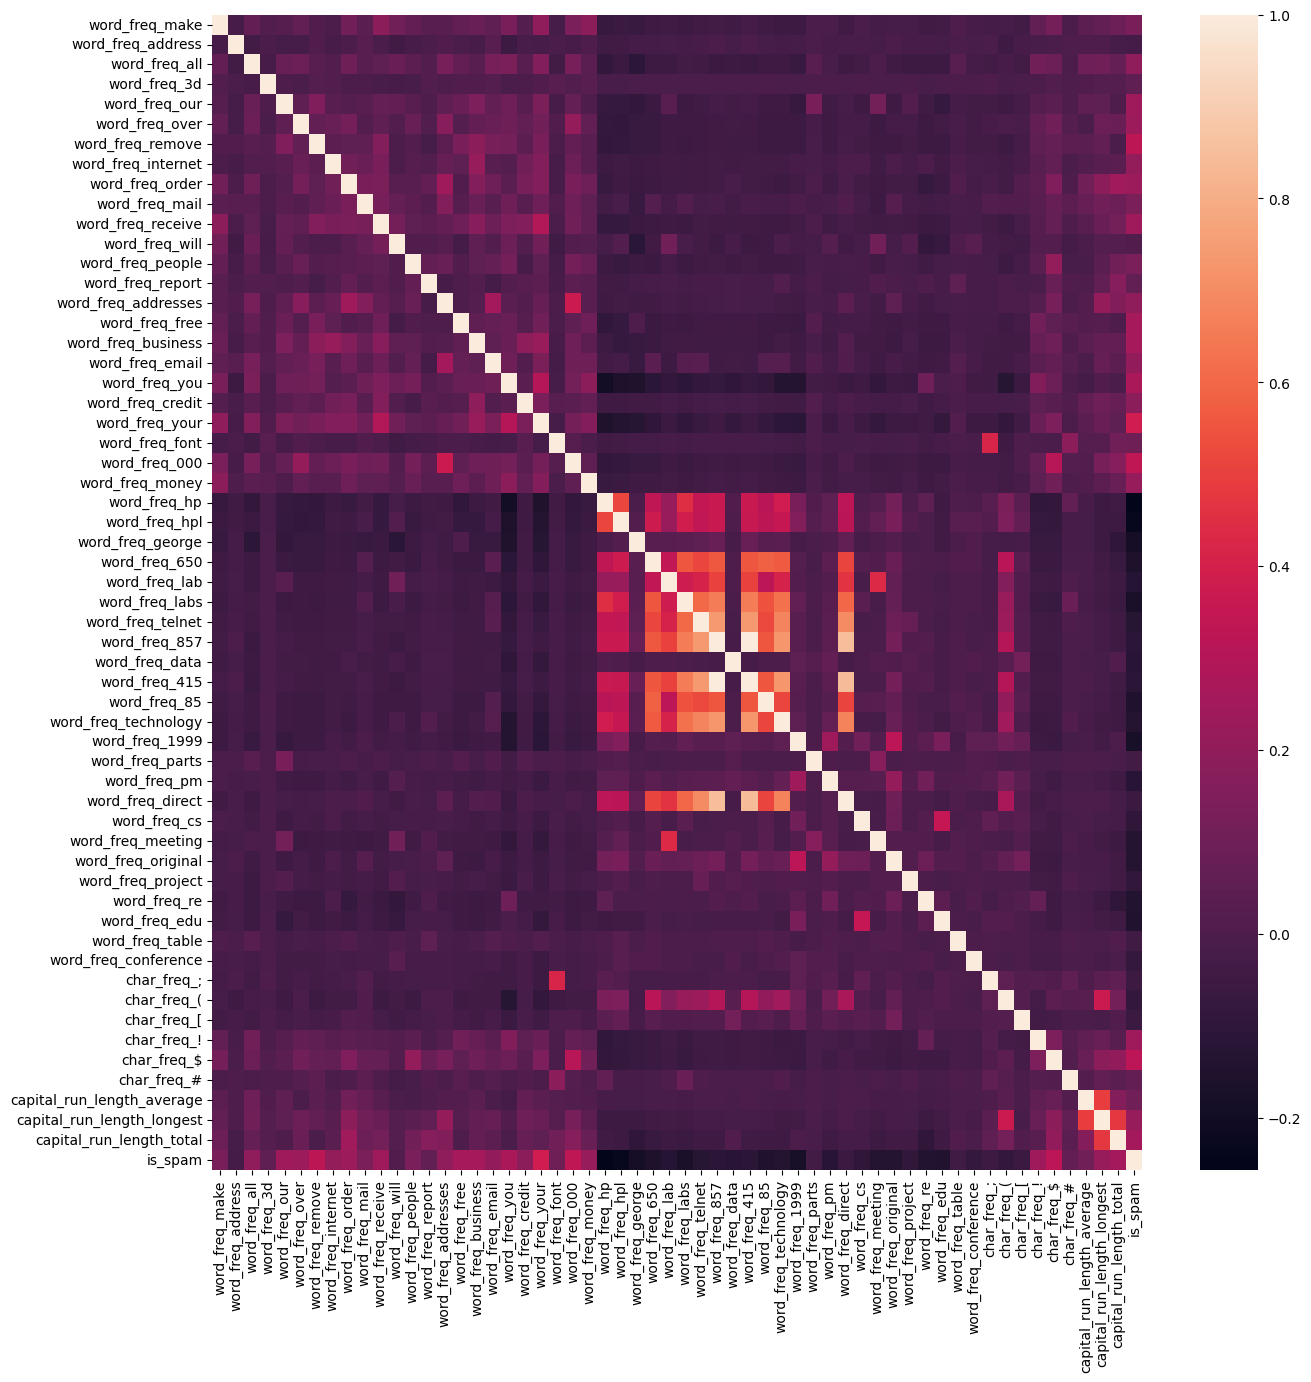

In [14]:
## correlation heatmap
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(cormat);


In [15]:
## Getting the top 10 correlations
cormat_unstacked = cormat.abs().unstack().sort_values(ascending=False)
cormat_unstacked = cormat_unstacked[cormat_unstacked < 1]
top_10_correlations = cormat_unstacked.drop_duplicates().head(10)
print(top_10_correlations)


word_freq_415         word_freq_857           0.996066
word_freq_857         word_freq_direct        0.848021
word_freq_direct      word_freq_415           0.845359
word_freq_857         word_freq_telnet        0.737555
word_freq_telnet      word_freq_415           0.735187
word_freq_857         word_freq_technology    0.729750
word_freq_technology  word_freq_415           0.727119
word_freq_direct      word_freq_telnet        0.699918
word_freq_telnet      word_freq_technology    0.677790
word_freq_technology  word_freq_direct        0.674249
dtype: float64


I decided to go further with these correlated features, and I took 2 of highest correlations (word_freq_415 vs word_freq_857) and (word_freq_857 vs word_freq_direct) and visualized them in a histogram, and the data points were labeled by the spam labels, the results were quite interesting.
The 2 histograms show us -apart from the highly positive correlation that we alreadt know-, that whenever the words 415/857 and 857/direct happen to be together in an email, that email is a spam message. This doesn't mean whenever 415 is frquent that is a spam email, correlation doesn't mean causation, but it's something that needs to be taken into consideration while implementing the model, as some algorithms would struggle more with this mulitcollinearity.

This extremely high correlation between some variables can indeed affect the performance of the model chosen. While Decision Trees algorithm are not  affected in terms of accuracy (they are affected in terms of computation but in our case we don't have a large dataset to worry about that). This finding will actually add on the previous finding of the slight imbalance, in addition to the high dimensionality, in choosing a tree based algorithm (Decision Tree, Random Forest) as they would perform much better within these circumstances.
However, since I'm not only going to choose decision tree algorithms, We need to pay attention to this Multicollinearity, and one of the methods to do so is Principal Component Analysis (PCA), that will aim to reduce the number of features, keeping only the most important ones, which will lead to reducing the most correlated features by keeping the most important information with the least number of features. Another method is to remove one of the features, but I won't be doing it because each data is different, I would have done if my columns were GDP and GDP per capita, where there is a mathematical operation that links them together, but the words 415 and 857 don't have any real relationship, so I'm keeping both. (Mustafa Erboga, 2024). It is important to mention that some features like capital_run_length_average, capital_run_length_average and capital_run_length_total are mathematically linked, but they don't have a strong correlation (0.49) so I'm keeping them as well.

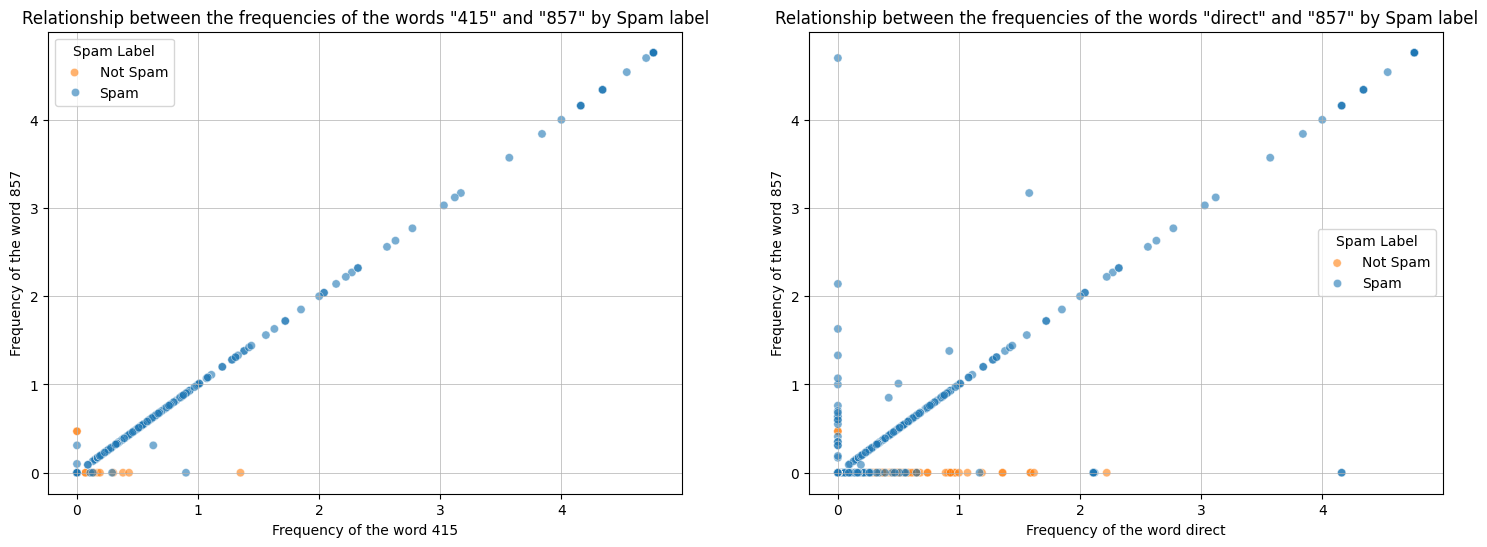

In [16]:
## Subplots of 2 of the most correlated features by spam label

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  

sns.scatterplot(
    x=df['word_freq_415'],  
    y=df['word_freq_857'],
    hue=df['is_spam'],
    alpha=0.6, 
    ax=axes[0]
)

axes[0].grid(True, linestyle='-', linewidth=0.5)
axes[0].set_xlabel("Frequency of the word 415")
axes[0].set_ylabel("Frequency of the word 857")
axes[0].set_title('Relationship between the frequencies of the words "415" and "857" by Spam label')
axes[0].legend(title='Spam Label', labels=['Not Spam', 'Spam'])


sns.scatterplot(
    x=df['word_freq_direct'],  
    y=df['word_freq_857'],
    hue=df['is_spam'],
    alpha=0.6,
    ax=axes[1]

)

axes[1].grid(True, linestyle='-', linewidth=0.5)
axes[1].set_xlabel("Frequency of the word direct")
axes[1].set_ylabel("Frequency of the word 857")
axes[1].set_title('Relationship between the frequencies of the words "direct" and "857" by Spam label')
axes[1].legend(title='Spam Label', labels=['Not Spam', 'Spam'])



plt.show()


Usually spam emails tend to have long sequences of capital letters and words in their content to catch attention.
So I went to explore that, and created another histogram to reveal the relationship between spam emails and average capital run length, and as expected, the average capital run length is generally higher in spam email compared to non-spam emails.
At first I only created one histogram, but then I decided to show the difference on 4 different scales based on the Average number of capital run, because there was some outliers, but even on the 0-50/0-100-0-200 scales, it is always the spam emails who have a higher average capital run length.

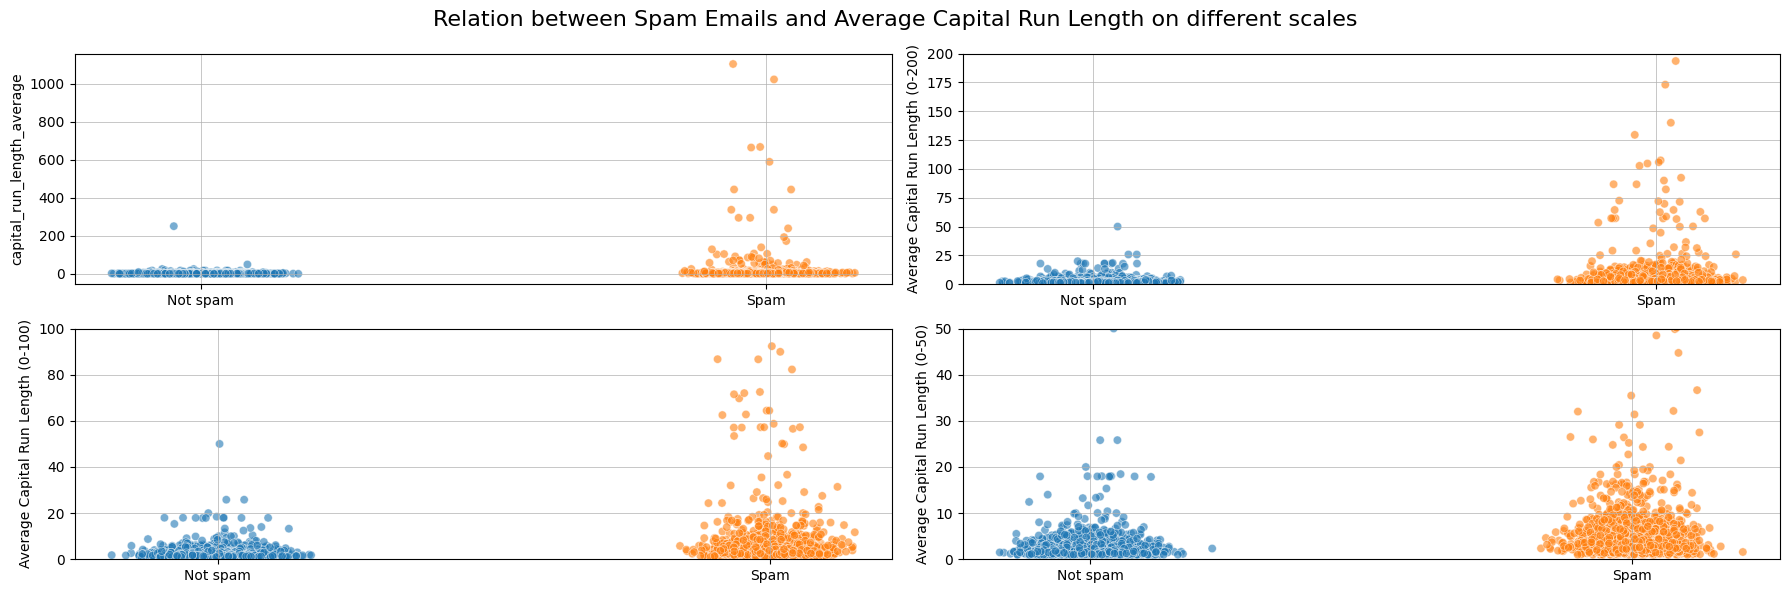

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(18, 6))  

sns.scatterplot(
    # I used jitter as is_spam is boolean so all points will have the same value (either spam or not spam), the plot would look like a straight line,
    # so jittering would spread the points to have a better representation in the plot
    x=np.random.normal(df['is_spam'], 0.05), 
    y=df['capital_run_length_average'],
    hue=df['is_spam'],
    alpha=0.6,    
    ax=axes[0,0],
    legend=False


)
axes[0,0].grid(True, linestyle='-', linewidth=0.5)
axes[0,0].set_xticks([0,1],['Not spam','Spam'])




sns.scatterplot(
    x=np.random.normal(df['is_spam'], 0.05), 
    y=df['capital_run_length_average'],
    hue=df['is_spam'],
    alpha=0.6,    
    ax=axes[0,1],
    legend=False

)
axes[0,1].grid(True, linestyle='-', linewidth=0.5)
axes[0,1].set_xticks([0,1],['Not spam','Spam'])
axes[0,1].set_ylabel("Average Capital Run Length (0-200)")
axes[0,1].set_ylim(0,200)




sns.scatterplot(
    x=np.random.normal(df['is_spam'], 0.05), 
    y=df['capital_run_length_average'],
    hue=df['is_spam'],
    alpha=0.6,    
    ax=axes[1,0],
    legend=False


)
axes[1,0].grid(True, linestyle='-', linewidth=0.5)
axes[1,0].set_xticks([0,1],['Not spam','Spam'])
axes[1,0].set_ylabel("Average Capital Run Length (0-100)")
axes[1,0].set_ylim(0,100)






sns.scatterplot(
    x=np.random.normal(df['is_spam'], 0.05), 
    y=df['capital_run_length_average'],
    hue=df['is_spam'],
    alpha=0.6,    
    ax=axes[1,1],
    legend=False

)
axes[1,1].grid(True, linestyle='-', linewidth=0.5)
axes[1,1].set_xticks([0,1],['Not spam','Spam'])
axes[1,1].set_ylabel("Average Capital Run Length (0-50)")
axes[1,1].set_ylim(0,50)

fig.suptitle("Relation between Spam Emails and Average Capital Run Length on different scales", fontsize=16)
plt.tight_layout()

plt.show()

The following summary table confirms the previous finding, and shows a full comparison between an average spam email and an average non spam email, where we see that spam emails have an average of 9.5 capital run length, compared to 2.3 capital run length, this feature will be highly important in identifying spam email in addition to many other features as well such as word_freq_free, word_freq_you, word_freq_your etc.. 
This will extremely helpful in the success of the model, since it's all based on probabilities, and the role of Machine learning is to find patterns linked to a certain variable, and in this case, without much effort we can easily spot that there are certain patterns linked to the type of email. Features like capital run length, frequency of certain words will play a massive role in identifying the type of email by the classification algorithm.

In [18]:
avg_email = df.groupby(by = 'is_spam').mean()
display(avg_email)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
is_spam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0.073479,0.244466,0.200581,0.000886,0.181040,0.044544,0.009383,0.038415,0.038049,0.167170,0.021711,0.536324,0.061664,0.042403,0.008318,0.073587,0.048346,0.097292,1.270341,0.007579,0.438702,0.045226,0.007088,0.017138,0.895473,0.431994,1.265265,0.193806,0.162794,0.165854,0.106033,0.077306,0.150986,0.077787,0.169455,0.141671,0.197744,0.018723,0.121679,0.083117,0.072027,0.216808,0.070581,0.126636,0.415760,0.287184,0.008160,0.051227,0.050281,0.158578,0.022684,0.109984,0.011648,0.021713,2.377301,18.214491,161.470947
True,0.152339,0.164650,0.403795,0.164672,0.513955,0.174876,0.275405,0.208141,0.170061,0.350507,0.118434,0.549972,0.143547,0.083574,0.112079,0.518362,0.287507,0.319228,2.264539,0.205521,1.380370,0.238036,0.247055,0.212879,0.017479,0.009173,0.001550,0.018798,0.000684,0.005968,0.001274,0.000518,0.014562,0.001776,0.006928,0.029515,0.043469,0.004710,0.012427,0.036718,0.000055,0.002443,0.008450,0.006244,0.125091,0.014727,0.001219,0.002101,0.020573,0.108970,0.008199,0.513713,0.174478,0.078877,9.519165,104.393271,470.619415


After that, I moved to check the distribution of my values, I created at first a boxplot of all features which was not a great idea as capital run lengths affected the scale, so I created a subset of my initial dataframe, that contains only frequencies words, i.e to have a general idea on how my values look like.
The results were not really good and further handling needs to be done, there was many outliers in the data withing most of the features and before doing any model implementation, while these outliers are normal and part of the 'real world' data, I wouldn't be getting rid of them as much as I will be doing some transformation to the values using scaling and transformation techniques which will reduce the skewness of our dataset (Suresh, 2020).

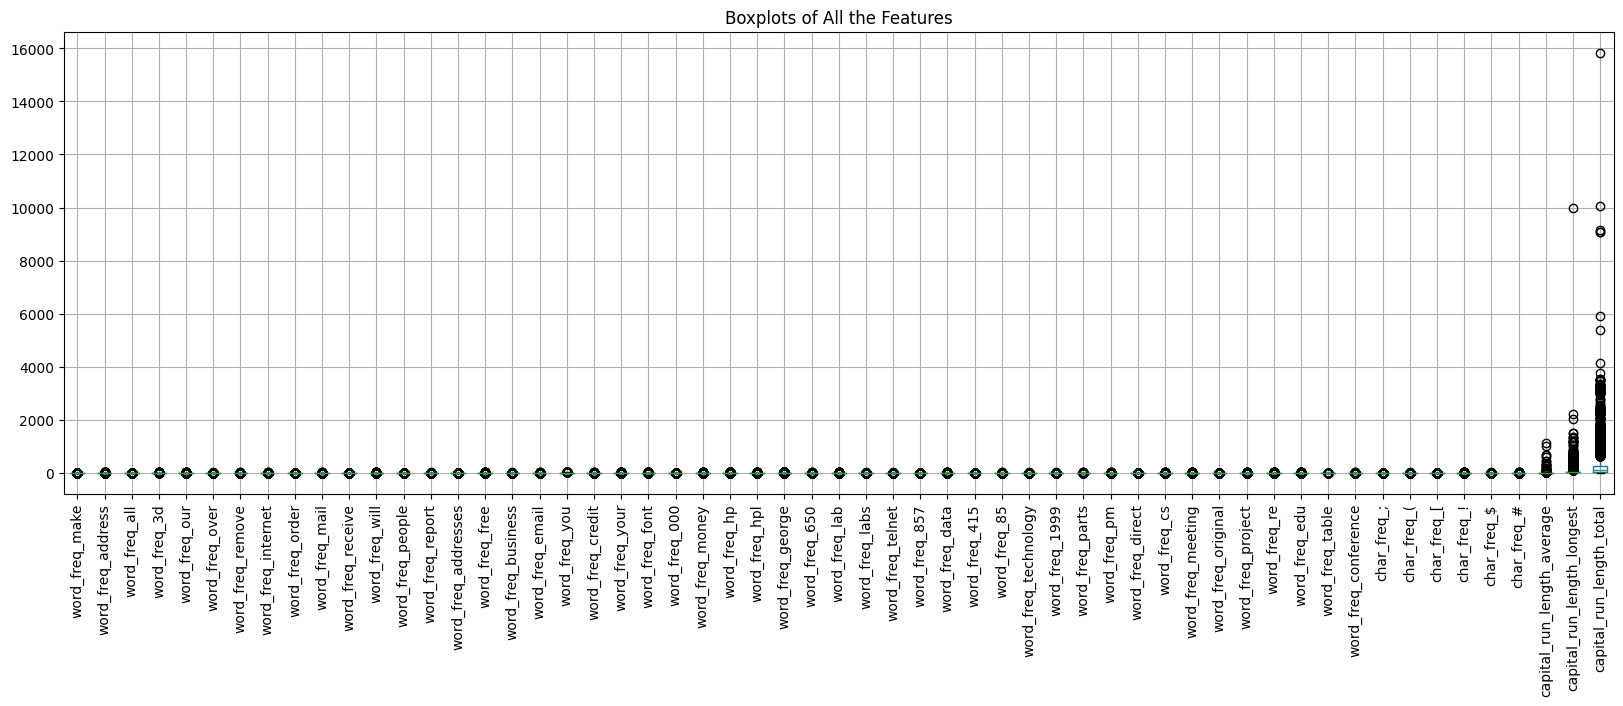

In [19]:
## Boxplot of all features
df.iloc[:,0:57].boxplot(figsize=(20, 6), rot=90)
plt.title('Boxplots of All the Features')
plt.show()

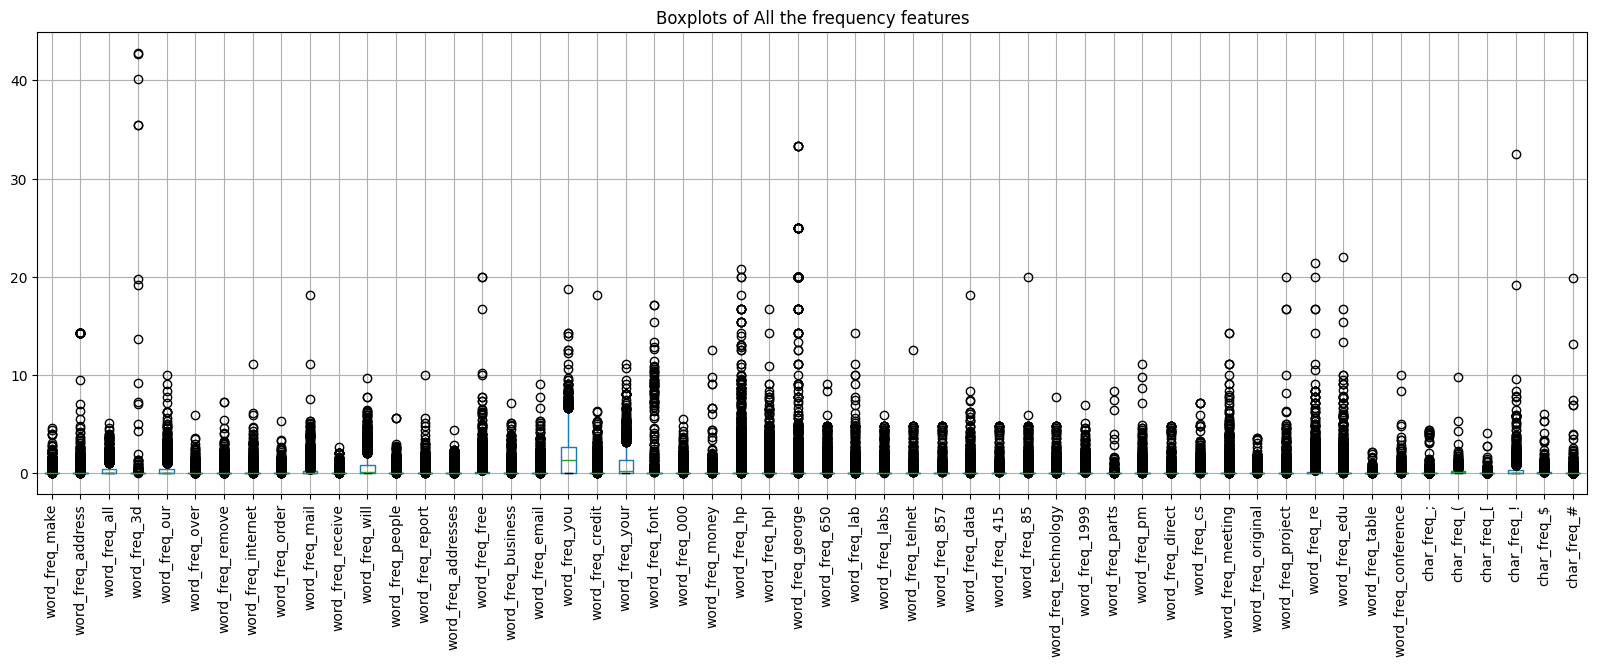

In [20]:
## I excluded the capital rung length related features
freq_df = df.iloc[:,0:54]
## Boxplot for the word frequencies features (float columns)
freq_df.boxplot(figsize=(20, 6), rot=90)
plt.title('Boxplots of All the frequency features')
plt.show()

# Summary of what I did:
### Initial Data Preparation:
In the previous cells, I started by exploring the dataset at first, noticed some inconsistencies about it so:
- I changed all the object data types into float
- Removed all the missing and unwanted values (zero, '?' etc..)
- Removed the Unnamed: 0 column due to its irrelevance
These steps were necessary as part of cleaning the data, as there's no point in visualising or implementing a model with dirty data.

### EDA:
Then I went more into the Exploratory Data Analysis, where I checked the distribution of the emails and noticed the very slight imbalance (60/40), explored the correlation heatmap and explored some of the most correlated features, identified multicollinearity. Then I compared the capital run length between spam and non spam-emails followed by a comparative summary table that outlines some keys characteristics that belong to spam emails such as longer capital run lengths, higher frequencies of certain wrods (free, you, your etc..) this finding is highly important when it comes to the distinction of the email type by the algorithm.

### More data preparation:
Based on all the previous findings especially the high dimensionality, the outliers in the values and the correlated features
the first algorithm I'm choosing is Random Forest, a decision tree algorithm, known for its robustness and managing all the previous findings. This algorithm doesn't require modification to the current dataset (no scaling, and no dimensionality reduction), however we will try to hypertune it and get the best parameters.
The other algorithms I will be choosing are the Naive Bayes(Gaussian) and K-Nearest Neighbors, these algorithms would require more data preparation in order to perform, in the following cells, I will be doing some scaling to the values, and Principal Component Analysis in order to reduce the Dimensionality.
For the scaling, we will use RobustScaler, scaling is essential before doing PCA as it is sensitive to the variance of each feature, and since we have some variance in our features, it will disproportionately affect the principal components (Jha, 2024). The reason I chose RobustScaler is because StandardScaler and MinMaxScaler are quite sensitive to outliers, while RobustScaler handles outliers and skewness in a much better way by using the median instead of mean which helps regarding the outliers we have and scales based on the Interquartile range (75th quantile - 25th quantile)   (Nalcin, 2022).

In [21]:
#Source: https://proclusacademy.com/blog/robust-scaler-outliers/
from sklearn.preprocessing import RobustScaler
robust_scaler  = RobustScaler()
df_scaled = robust_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns= df.columns)

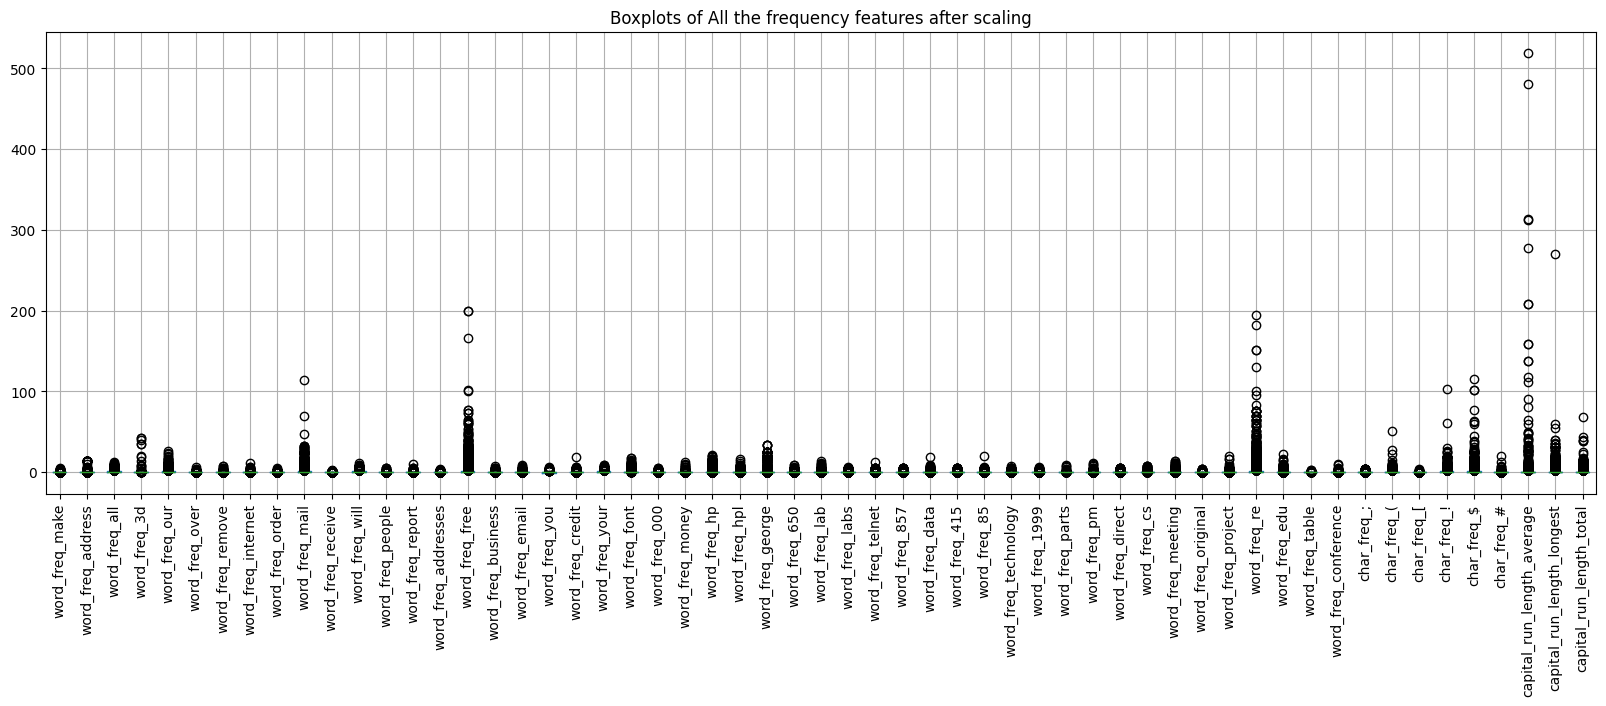

In [22]:
## Boxplot for the word frequencies features (float columns)
df_scaled.iloc[:,0:57].boxplot(figsize=(20, 6), rot=90)
plt.title('Boxplots of All the frequency features after scaling')
plt.show()

We can see that the values are now within a much better range, the outliers are still there, but with much less influence, and most of the values are within a readable range as shown in the plots above and below

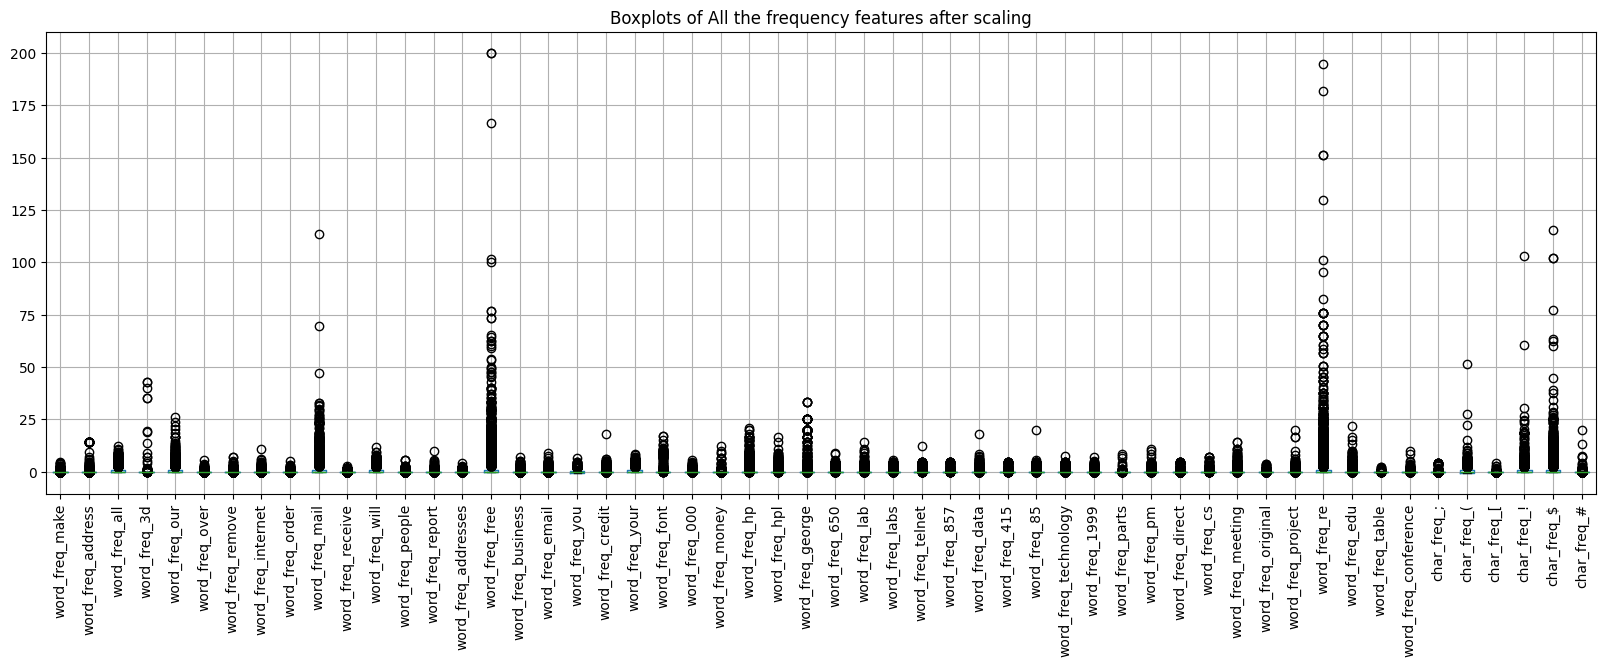

In [23]:
freq_df = df_scaled.iloc[:,0:54]
## Boxplot for the word frequencies features (float columns)
freq_df.boxplot(figsize=(20, 6), rot=90)
plt.title('Boxplots of All the frequency features after scaling')
plt.show()

Even though I've scaled the data earlier on, and showed the differences with plots, I will be doing it again later on to the training and tesing sets, This approach would avoid Data leakage, which is the exposure of information between test and training data as they must be independent. This usually happens in the preprocessing steps such as standardization and PCA.
By doing standardization and PCA to the initial df, we would expose the model to the testing data, and the model will perform good in numbers, but this will result in overfitting and test results will be misleading (Rukshan Pramoditha, 2022).


In [24]:
from sklearn.model_selection import train_test_split
X = df.drop(columns='is_spam')
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state= 11)

In [25]:
# Robust scaler previously defined
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test) # We don't fit on the test set, as it would take new median and IQR leading to bias in the model

In [26]:
#source: https://builtin.com/machine-learning/pca-in-python
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_final = pca.fit_transform(X_train_scaled)
X_test_final = pca.transform(X_test_scaled)

## KNN Classifier

### Default KNN Classifier
The default classifier, that has number of neighbors (k) equal to  5, gave 90% accuracy overall.
#### -True Positives (TP=319):
The model correctly identified 319 spam emails.
#### -True Negatives (TN=514):
The model correctly identified 514 non-spam emails.
#### -False Positives (FP=40):
The model incorrectly classified 40 non-spam emails as spam emails.
#### -False Negative (FN=48):
The model incorrectly classified 48 spam emails as non-spam emails.

###  KNN Classifier after hyperparameter tuning
The Hyperparameter tuning, that changed the number of neighbors to 7, the weights to distance (default is uniform) and Power parameter to 2 has slightly increased the overall accuracy to 91% and:
Reduce the false Positives from 40 to 37, meaning we got less non-spam emails incorrectly classified as spam which is a good improvement and we want this as low as possible. We don't want non-spam emails to be classified as spam because they may containt important information.
Also the false Negative became 42 (previously 48) which means the model now managed to predict less spam emails as non-spam, which means we have slightly improved the filter.

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


In [28]:
# Default KNN (k=5)
knn = KNeighborsClassifier()
knn.fit(X_train_final, y_train)

KNeighborsClassifier()

In [29]:
y_pred = knn.predict(X_test_final)
print(confusion_matrix(y_test, y_pred))

[[514  40]
 [ 48 319]]


In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.91      0.93      0.92       554
        True       0.89      0.87      0.88       367

    accuracy                           0.90       921
   macro avg       0.90      0.90      0.90       921
weighted avg       0.90      0.90      0.90       921



In [31]:
# Define the hyperparameter grid
# source: https://www.linkedin.com/pulse/improve-model-hyperparameter-tuning-k-nearest-muctary-abdallah-1e
param_grid = {'n_neighbors': np.arange(1, 21),
              'weights': ['uniform', 'distance', None],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}

In [32]:
# define the grid search with KNN parameters
grid = GridSearchCV(knn,param_grid,cv=5,scoring='accuracy')
# train the grid 
grid.fit(X_train_final, y_train)
# print the best parameters
print("Best Hyperparameters:", grid.best_params_)


Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': np.int64(7), 'p': 1, 'weights': 'distance'}


In [33]:
# add the best hyperparameters to the knn instance 
best_knn = KNeighborsClassifier(n_neighbors=7,weights='distance', algorithm='auto',  p=1)

In [34]:
# train the model with best hyperparameters
best_knn.fit(X_train_final, y_train)
y_pred = best_knn.predict(X_test_final)
print(confusion_matrix(y_test, y_pred))

[[517  37]
 [ 42 325]]


In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.92      0.93      0.93       554
        True       0.90      0.89      0.89       367

    accuracy                           0.91       921
   macro avg       0.91      0.91      0.91       921
weighted avg       0.91      0.91      0.91       921

